# Skymaps of NS-AMC signals

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import os

import healpy as hp

from tqdm import tqdm

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=18)

In [3]:
import sys
sys.path.append('../')
import dirs

In [4]:
IDstr = "_wStripping"

AS_CUT = True
cut_text = ""
if (AS_CUT):
    cut_text = "_AScut"

In [5]:
try:
    long_PL, lat_PL, mean_flux_PL = np.loadtxt(dirs.data_dir + 'Interaction_params_PL%s%s.txt'%(cut_text,IDstr), unpack=True, usecols=(1,2,4))
except FileNotFoundError as err:
    long_PL, lat_PL, mean_flux_PL = np.loadtxt(dirs.data_dir + 'Interaction_params_PL%s%s_short.txt'%(cut_text,IDstr), unpack=True, usecols=(1,2,4))
    
try:
    long_NFW, lat_NFW, mean_flux_NFW = np.loadtxt(dirs.data_dir + 'Interaction_params_NFW%s%s.txt'%(cut_text,IDstr), unpack=True, usecols=(1,2,4))
except FileNotFoundError as err:
    long_NFW, lat_NFW, mean_flux_NFW = np.loadtxt(dirs.data_dir + 'Interaction_params_NFW%s%s_short.txt'%(cut_text,IDstr), unpack=True, usecols=(1,2,4))

#### Calculating 68% containment for PL profiles

In [6]:
theta_PL = (180/np.pi)*np.arccos(np.cos(long_PL*np.pi/180)*np.cos(lat_PL*np.pi/180))
theta_PL_68 = np.quantile(np.abs(theta_PL), 0.68)
print(theta_PL_68)

7.239636830626351


#### Calculating containment for NFW profiles

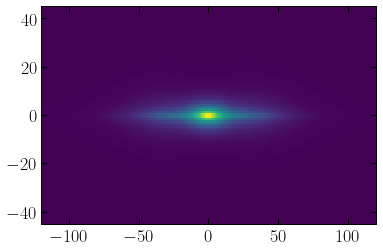

In [7]:
long_bins_dense = np.linspace(-120, 120, 241)
lat_bins_dense = np.linspace(-45, 45, 91)

long_c_dense = long_bins_dense[1:] + np.diff(long_bins_dense)
lat_c_dense = lat_bins_dense[1:] + np.diff(lat_bins_dense)

h_all_dense,_,_,_ = plt.hist2d(long_NFW, lat_NFW, bins=(long_bins_dense, lat_bins_dense), density=True)#, range=None, density=False, weights=None, cmin=None, cmax=None, cmap=value)

In [8]:
#Find threshold value:
#print(len(counts_NFW))
count_list = np.geomspace(1e-6, 1, 1000)
for count in count_list:
    #print(np.sum(counts_NFW[counts_NFW > count]))
    if (np.sum(h_all_dense[h_all_dense > count]) < 0.68):
        contain68_NFW = count
        break
print(contain68_NFW)
print(np.sum(h_all_dense[h_all_dense > 1e-10]))
print(np.sum(h_all_dense[h_all_dense > contain68_NFW]))

0.00019421746814890265
1.0
0.6768302899677232


In [9]:
#### Find curves to describe this region
#hp.ang2pix(N_side, lon, lat, lonlat=True)

lon_list = 1.0*long_c_dense
lat_list_bottom = 0.0*lon_list
lat_list_top = 0.0*lon_list
lat_range = 1.0*lat_c_dense
i0 = 0
for i, lon in enumerate(lon_list):
    #print(i)
    for j in range(int(len(lat_range)/2)-1, len(lat_range)):
        lat = lat_range[j]
        #print(lat)
        if (h_all_dense[i,j] < contain68_NFW):
            lat_list_top[i] = lat
            if ((i0 == 0) and (lat != 0)):
                i0 = i
            #print(i0, i)
            break
            
for i, lon in enumerate(lon_list):
    #print(i)
    for j in range(int(len(lat_range)/2)-1, len(lat_range)):
        lat = lat_range[j]
        if (h_all_dense[i,j] < contain68_NFW):
            lat_list_bottom[i] = -lat
            #if ((i0 == 0) and (lat != 0)):
            #    i0 = i
            #print(i0, i)
            break

imin = np.where(lat_list_top > 1.1)[0][0]
imax = np.where(lat_list_top > 1.1)[0][-1]
lon_list = lon_list[imin:imax]
lat_list_bottom = lat_list_bottom[imin:imax]
lat_list_top = lat_list_top[imin:imax]

#p = np.polyfit(lon_list, lat_list, 1)
#print(p)

lon_list_NFW = np.concatenate((lon_list, lon_list[::-1]))
lat_list_NFW = np.concatenate((lat_list_top, lat_list_bottom[::-1]))
#lat_line = np.polyval(p, lon_list)
#lat_list_NFW = np.concatenate((lat_line, -lat_line, -lat_line, lat_line))
lon_list_NFW = np.append(lon_list_NFW,lon_list_NFW[0])
lat_list_NFW = np.append(lat_list_NFW,lat_list_NFW[0])

#### Cartesian maps

In [10]:
long_bins = np.linspace(-120, 120, 121)
lat_bins = np.linspace(-45, 45, 46)
long_c = long_bins[1:] + np.diff(long_bins)
lat_c = lat_bins[1:] + np.diff(lat_bins)

width = long_bins[-1] - long_bins[0]
height = lat_bins[-1] - lat_bins[0]

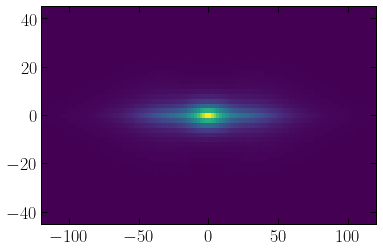

In [11]:
h_all,_,_,_ = plt.hist2d(long_NFW, lat_NFW, bins=(long_bins, lat_bins), density=True)#, range=None, density=False, weights=None, cmin=None, cmax=None, cmap=value)

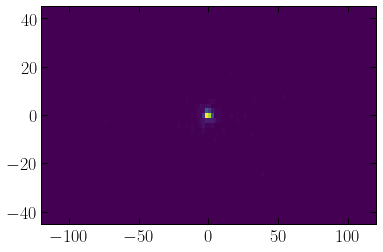

In [12]:
h_bright,_,_,_ = plt.hist2d(long_NFW[mean_flux_NFW > 1e3], lat_NFW[mean_flux_NFW > 1e3], bins=(long_bins, lat_bins), density=True)#, range=None, density=False, weights=None, cmin=None, cmax=None, cmap=value)

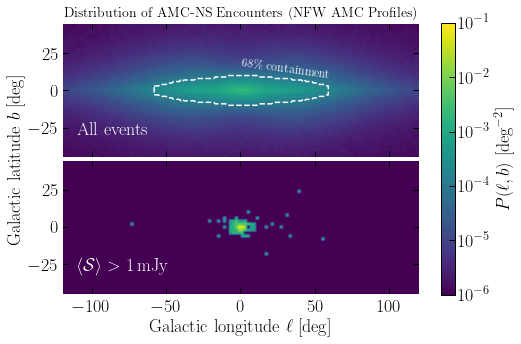

In [13]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8,5))
for ax in axes:
    plt.setp(ax.spines.values(), color='white')
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')

P_min = 1e-6
P_max = 1e-1
    
im0 = axes[0].imshow(np.log10(h_all.T + P_min), 
                     extent=[np.min(long_bins), np.max(long_bins), np.min(lat_bins), np.max(lat_bins)],
                     vmin = np.log10(P_min), vmax = np.log10(P_max))
axes[0].set_xticklabels([])
axes[0].text(-110, -30, "All events", color='white')
axes[0].set_aspect(1)

axes[0].plot(lon_list_NFW, lat_list_NFW, linestyle='--', color='white')

axes[0].text(0.01, 14, r'$68\%$ containment', color='white', rotation=-8, va='center', fontsize=12)

im1 = axes[1].imshow(np.log10(h_bright.T + P_min),
                    extent=[np.min(long_bins), np.max(long_bins), np.min(lat_bins), np.max(lat_bins)],
                     vmin = np.log10(P_min), vmax = np.log10(P_max))
axes[1].set_xlabel("Galactic longitude $\ell$ [deg]")
#axes[0].set_ylabel("Galactic longitude $\ell$ [$^\circ$]")
#axes[1].set_ylabel("Galactic latitude $b$ [deg]")
axes[1].text(-110, -30, r"$\langle \mathcal{S} \rangle > 1 \,\mathrm{mJy}$", color='white')
axes[1].set_aspect(1)

fig.text(0.03, 0.5, "Galactic latitude $b$ [deg]", va='center', rotation='vertical')



axes[0].set_title("Distribution of AMC-NS Encounters (NFW AMC Profiles)", fontsize=14)

fig.subplots_adjust(hspace=0.01)

colticks = np.linspace(-6, -1, 6)
colticklabs = [r'$10^{' + str(int(ct)) + '}$' for ct in colticks]

cbar = fig.colorbar(im0, ax=axes, label=r'$P(\ell, b)$ [deg$^{-2}$]', ticks=colticks)#, extend='min')
cbar.ax.set_yticklabels(colticklabs)

plt.savefig('../../plots/Skymaps_NFW_cartesian_log%s.pdf'%(IDstr,), bbox_inches='tight')
plt.show()


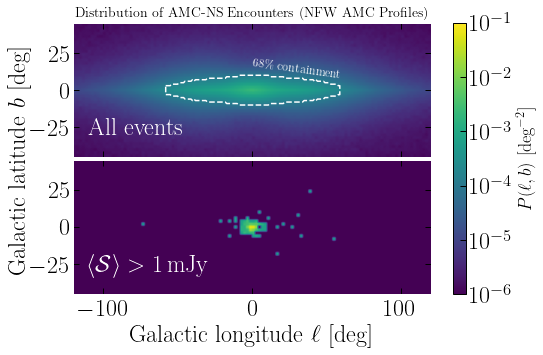

In [14]:
rc('font', size=24)
#rc('axes.labelsize', fontsize=24)

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8,5))

for ax in axes:
    plt.setp(ax.spines.values(), color='white')
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')

P_min = 1e-6
P_max = 1e-1
    
im0 = axes[0].imshow(np.log10(h_all.T + P_min), 
                     extent=[np.min(long_bins), np.max(long_bins), np.min(lat_bins), np.max(lat_bins)],
                     vmin = np.log10(P_min), vmax = np.log10(P_max))
axes[0].set_xticklabels([])
axes[0].text(-110, -30, "All events", color='white')
axes[0].set_aspect(1)

axes[0].plot(lon_list_NFW, lat_list_NFW, linestyle='--', color='white')

axes[0].text(0.01, 14, r'$68\%$ containment', color='white', rotation=-8, va='center', fontsize=12)

im1 = axes[1].imshow(np.log10(h_bright.T + P_min),
                    extent=[np.min(long_bins), np.max(long_bins), np.min(lat_bins), np.max(lat_bins)],
                     vmin = np.log10(P_min), vmax = np.log10(P_max))
axes[1].set_xlabel("Galactic longitude $\ell$ [deg]", fontsize=24)
#axes[0].set_ylabel("Galactic longitude $\ell$ [$^\circ$]")
#axes[1].set_ylabel("Galactic latitude $b$ [deg]")
axes[1].text(-110, -30, r"$\langle \mathcal{S} \rangle > 1 \,\mathrm{mJy}$", color='white')
axes[1].set_aspect(1)

fig.text(0.01, 0.5, "Galactic latitude $b$ [deg]", va='center', rotation='vertical')



axes[0].set_title("Distribution of AMC-NS Encounters (NFW AMC Profiles)", fontsize=14)

fig.subplots_adjust(hspace=0.01)

colticks = np.linspace(-6, -1, 6)
colticklabs = [r'$10^{' + str(int(ct)) + '}$' for ct in colticks]

cbar = fig.colorbar(im0, ax=axes, label=r'$P(\ell, b)$ [deg$^{-2}$]', ticks=colticks)#, extend='min')
cbar.ax.set_yticklabels(colticklabs)

plt.savefig('../../plots/Skymaps_NFW_cartesian_log_large%s.pdf'%(IDstr,), bbox_inches='tight')
plt.show()
rc('font', size=18)

#### Mollweide Skymaps

In [15]:
N_side = 25

In [16]:
pix_PL = hp.pixelfunc.ang2pix(N_side, long_PL, lat_PL, nest=False, lonlat=True)
pix_NFW = hp.pixelfunc.ang2pix(N_side, long_NFW, lat_NFW, nest=False, lonlat=True)

In [17]:
npix = hp.pixelfunc.nside2npix(N_side)

In [18]:
counts_PL = np.zeros(npix)
counts_NFW = np.zeros(npix)
for i in tqdm(range(npix)):
    counts_PL[i] = np.count_nonzero(pix_PL == i)
    counts_NFW[i] = np.count_nonzero(pix_NFW == i)
    
counts_PL /= np.sum(counts_PL)
counts_NFW /= np.sum(counts_NFW)

100%|██████████| 7500/7500 [02:12<00:00, 56.69it/s]


In [19]:
counts_NFW_bright = np.zeros(npix)
for i in tqdm(range(npix)):
    counts_NFW_bright[i] = np.count_nonzero(pix_NFW[mean_flux_NFW > 1e3] == i)
    
counts_NFW_bright /= np.sum(counts_NFW_bright)

100%|██████████| 7500/7500 [02:59<00:00, 41.85it/s]


/usr/local/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/usr/local/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/usr/local/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To 

NameError: name 'long_PL_68' is not defined

<Figure size 432x288 with 0 Axes>

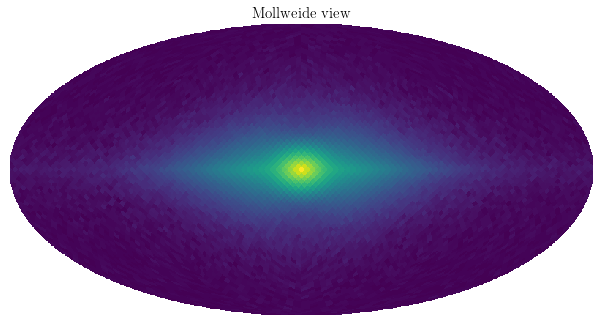

In [20]:
plt.figure()
#hp.mollview(np.log10((counts_PL + 1)/np.sum(counts_PL)), cbar=False)
#hp.mollview((counts_PL + 1e-6)/np.sum(counts_PL), cbar=False)
hp.mollview(np.log10(counts_PL + 1e-6), cbar=False)
#hp.graticule(30,color='white')

b_list = np.linspace(-90, 90,1000)



#68% values
Lon_max = long_PL_68
Lat_max = lat_PL_68

#hp.projplot(Lon_max + np.zeros(100),np.linspace(-Lat_max, Lat_max, 100), lonlat=True,color='w', linestyle='-.',lw=2)
#hp.projplot(-Lon_max + np.zeros(100),np.linspace(-Lat_max, Lat_max, 100), lonlat=True,color='w', linestyle='-.',lw=2)

#hp.projplot(np.linspace(-Lon_max, Lon_max, 100),-Lat_max + np.zeros(100), lonlat=True,color='w', linestyle='-.',lw=2)
#hp.projplot(np.linspace(-Lon_max, Lon_max, 100),Lat_max + np.zeros(100), lonlat=True,color='w', linestyle='-.',lw=2)

#hp.projplot(lon_list_PL,lat_list_PL, lonlat=True,color='w', linestyle='-.',lw=2)

for lat in np.arange(-180, 180, 30):
    hp.projplot(0.0*b_list + lat,b_list, lonlat=True,color='w', linestyle=':',lw=0.75)

    
hp.projplot(0.0*b_list + 180,b_list, lonlat=True, color='w',lw=3)
hp.projplot(0.0*b_list + 179.9,b_list, lonlat=True, color='w',lw=3)




#hp.projplot(0.0*b_list + 179.9,b_list, lonlat=True, color='w',lw=2)


plt.text(1.3, 0.75,r'$+60^\circ$')
plt.text(1.85, 0.4,r'$+30^\circ$')

plt.text(1.85, -0.45,r'$-30^\circ$')
plt.text(1.3, -0.8,r'$-60^\circ$')

#props = dict(facecolor='white', alpha=0.25, edgecolor='none', boxstyle="round,pad=0.25,rounding_size=0.5")
props=None

plt.text(0.2, -0.25, r'$30^\circ$', color='white', rotation=84, bbox=props, va='center')
plt.text(0.51, -0.25, r'$60^\circ$', color='white', rotation=79, bbox=props, va='center')
plt.text(0.83, -0.25, r'$90^\circ$', color='white', rotation=74, bbox=props, va='center')
plt.text(1.12, -0.25, r'$120^\circ$', color='white', rotation=69, bbox=props, va='center')
plt.text(1.45, -0.25, r'$150^\circ$', color='white', rotation=63, bbox=props, va='center')


l_list = np.linspace(-180, 180, 1000)

for lon in np.arange(-90, 90, 30):
    hp.projplot(l_list,0.0*l_list + lon, lonlat=True,color='w', linestyle=':', lw=0.75)
    
plt.title("Distribution of AMC-NS Encounters (Power-Law AMC Profiles)")

plt.savefig("../../plots/SkyMap_Moll_PL%s%s.pdf"%(cut_text,IDstr), bbox_inches="tight")
plt.show()

#### Calculating containment for the Mollweide maps

In [ ]:
#Find threshold value:
#print(len(counts_NFW))
count_list = np.geomspace(1e-6, 1, 100)
for count in count_list:
    #print(np.sum(counts_NFW[counts_NFW > count]))
    if (np.sum(counts_NFW[counts_NFW > count]) < 0.68):
        contain68_NFW = count
        break
print(contain68_NFW)
print(np.sum(counts_NFW[counts_NFW > contain68_NFW]))

In [ ]:
#### Find curves to describe this region
#hp.ang2pix(N_side, lon, lat, lonlat=True)

lon_list = np.linspace(-180, 180, 180)
lat_list_bottom = 0.0*lon_list
lat_list_top = 0.0*lon_list
lat_range = np.linspace(0, 90, 180)
i0 = 0
for i, lon in enumerate(lon_list):
    #print(i)
    for lat in lat_range:
        ipix = hp.ang2pix(N_side, lon, lat, lonlat=True)
        if (counts_NFW[ipix] < contain68_NFW):
            lat_list_top[i] = lat
            if ((i0 == 0) and (lat != 0)):
                i0 = i
            #print(i0, i)
            break
            
for i, lon in enumerate(lon_list):
    #print(i)
    for lat in lat_range:
        ipix = hp.ang2pix(N_side, lon, -lat, lonlat=True)
        if (counts_NFW[ipix] < contain68_NFW):
            lat_list_bottom[i] = -lat
            #if ((i0 == 0) and (lat != 0)):
            #    i0 = i
            #print(i0, i)
            break

imax = np.where(lat_list_top > 0)[0][-1]
lon_list = lon_list[i0:imax]
lat_list_bottom = lat_list_bottom[i0:imax]
lat_list_top = lat_list_top[i0:imax]

#p = np.polyfit(lon_list, lat_list, 1)
#print(p)

lon_list_NFW = np.concatenate((lon_list, lon_list[::-1]))
lat_list_NFW = np.concatenate((lat_list_top, lat_list_bottom[::-1]))
#lat_line = np.polyval(p, lon_list)
#lat_list_NFW = np.concatenate((lat_line, -lat_line, -lat_line, lat_line))

In [ ]:
plt.figure(figsize=(6,5))
#hp.mollview(np.log10((counts_NFW+1)/np.sum(counts_NFW)), cbar=False)
#hp.mollview((counts_NFW+1e-6)/np.sum(counts_NFW), cbar=False)#, cbar=True)
hp.mollview(np.log10(counts_NFW+1e-6), cbar=False)#, cbar=True)
#hp.graticule(30,color='white')

b_list = np.linspace(-90, 90,1000)

#90% values
#Lon_max = 74
#Lat_max = 40

#68% values
#Lon_max = long_NFW_68
#Lat_max = lat_NFW_68


#hp.projplot(Lon_max + np.zeros(100),np.linspace(-Lat_max, Lat_max, 100), lonlat=True,color='w', linestyle='-.',lw=2)
#hp.projplot(-Lon_max + np.zeros(100),np.linspace(-Lat_max, Lat_max, 100), lonlat=True,color='w', linestyle='-.',lw=2)

#hp.projplot(np.linspace(-Lon_max, Lon_max, 100),-Lat_max + np.zeros(100), lonlat=True,color='w', linestyle='-.',lw=2)
#hp.projplot(np.linspace(-Lon_max, Lon_max, 100),Lat_max + np.zeros(100), lonlat=True,color='w', linestyle='-.',lw=2)

hp.projplot(lon_list_NFW,lat_list_NFW, lonlat=True,color='w', linestyle='-.',lw=2)

for lat in np.arange(-180, 180, 30):
    hp.projplot(0.0*b_list + lat,b_list, lonlat=True,color='w', linestyle=':',lw=0.75)

hp.projplot(0.0*b_list + 180,b_list, lonlat=True, color='w',lw=3)
hp.projplot(0.0*b_list + 179.9,b_list, lonlat=True, color='w',lw=3)

#hp.projplot(0.0*b_list + 179.9,b_list, lonlat=True, color='w',lw=2)

plt.text(1.3, 0.75,r'$+60^\circ$', fontsize=20)
plt.text(1.85, 0.4,r'$+30^\circ$', fontsize=20)

plt.text(1.85, -0.45,r'$-30^\circ$', fontsize=20)
plt.text(1.3, -0.8,r'$-60^\circ$', fontsize=20)

#props = dict(facecolor='white', alpha=0.25, edgecolor='none', boxstyle="round,pad=0.25,rounding_size=0.5")
props=None

plt.text(0.19, -0.25, r'$30^\circ$', color='white', rotation=84, bbox=props, va='center', fontsize=20)
plt.text(0.50, -0.25, r'$60^\circ$', color='white', rotation=79, bbox=props, va='center', fontsize=20)
plt.text(0.82, -0.25, r'$90^\circ$', color='white', rotation=74, bbox=props, va='center', fontsize=20)
plt.text(1.11, -0.25, r'$120^\circ$', color='white', rotation=69, bbox=props, va='center', fontsize=20)
plt.text(1.43, -0.25, r'$150^\circ$', color='white', rotation=61, bbox=props, va='center', fontsize=20)
#plt.text(-0.55, 0.20, r'$68\%$ containment', color='white', rotation=0, bbox=props, va='center', fontsize=16)

plt.text(0.01, 0.14, r'$68\%$ containment', color='white', rotation=-12, bbox=props, va='center', fontsize=14)

l_list = np.linspace(-180, 180, 1000)

for lon in np.arange(-90, 90, 30):
    hp.projplot(l_list,0.0*l_list + lon, lonlat=True,color='w', linestyle=':', lw=0.75)

plt.title("Distribution of AMC-NS Encounters (NFW AMC Profiles)", fontsize=18)


plt.savefig("../../plots/SkyMap_Moll_NFW_logscale%s.pdf"%(IDstr,), bbox_inches="tight")
plt.show()